In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 94% 312M/331M [00:01<00:00, 225MB/s]
100% 331M/331M [00:01<00:00, 217MB/s]


In [4]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [5]:
dataset_path = '/content/utkface_aligned_cropped/UTKFace'

In [7]:
# Lists to store extracted information
ages = []
genders = []
races = []
img_paths = []

# Function to extract information from filename
def extract_info_from_filename(filename):
    try:
        # Split the filename by '_'
        parts = filename.split('_')
        # Extract age, gender, race assuming the format: age_gender_race_some_id.jpg
        extracted_age = int(parts[0])
        extracted_gender = int(parts[1])
        extracted_race = int(parts[2])
        return extracted_age, extracted_gender, extracted_race
    except (ValueError, IndexError) as e:
        # Handle cases where the filename does not conform to the expected format
        print(f"Skipping file {filename}: {e}")
        return None

In [8]:
# Iterate over files in the dataset directory
for file in os.listdir(dataset_path):
    # Extract information from filename
    info = extract_info_from_filename(file)
    if info:
        # Append extracted information to lists
        extracted_age, extracted_gender, extracted_race = info
        ages.append(extracted_age)
        genders.append(extracted_gender)
        races.append(extracted_race)
        img_paths.append(os.path.join(dataset_path, file))



Skipping file 61_1_20170109142408075.jpg.chip.jpg: invalid literal for int() with base 10: '20170109142408075.jpg.chip.jpg'
Skipping file 61_1_20170109150557335.jpg.chip.jpg: invalid literal for int() with base 10: '20170109150557335.jpg.chip.jpg'
Skipping file 39_1_20170116174525125.jpg.chip.jpg: invalid literal for int() with base 10: '20170116174525125.jpg.chip.jpg'


In [9]:
# Convert lists to numpy arrays for model input
ages = np.array(ages)
genders = np.array(genders)
races = np.array(races)

In [10]:
df = pd.DataFrame({'age':ages,'gender':genders,'race':races, 'img':img_paths})

In [11]:
df.head()

,age,gender,race,img
0,28,1,0,/content/utkface_aligned_cropped/UTKFace/28_1_...
1,26,1,0,/content/utkface_aligned_cropped/UTKFace/26_1_...
2,16,1,4,/content/utkface_aligned_cropped/UTKFace/16_1_...
3,2,0,4,/content/utkface_aligned_cropped/UTKFace/2_0_4...
4,35,0,1,/content/utkface_aligned_cropped/UTKFace/35_0_...


In [12]:
df.race.nunique()

5

In [13]:
from sklearn.model_selection import train_test_split

# Split the data
train_img_paths, test_img_paths, train_ages, test_ages, train_genders, test_genders, train_races, test_races = train_test_split(
    img_paths, ages, genders, races, test_size=0.2, random_state=42
)

In [14]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the race labels (assuming race labels are originally integers from 0 to 4)
train_races = to_categorical(train_races, num_classes=5)
test_races = to_categorical(test_races, num_classes=5)

print('Corrected shape of race labels:', train_races.shape)  # Should be (18964, 5)


Corrected shape of race labels: (18964, 5)


In [25]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a data generator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom data generator for multi-output model
def custom_data_generator(img_paths, ages, genders, races, batch_size):
    while True:
        for start in range(0, len(img_paths), batch_size):
            end = min(start + batch_size, len(img_paths))
            batch_img_paths = img_paths[start:end]
            batch_ages = ages[start:end]
            batch_genders = genders[start:end]
            batch_races = races[start:end]

            batch_images = []
            for img_path in batch_img_paths:
                img = load_img(img_path, target_size=(224, 224))  # Adjust size as needed
                img_array = img_to_array(img)
                batch_images.append(img_array)

            batch_images = np.array(batch_images)
            # Use next() instead of .next()
            batch_images = next(datagen.flow(batch_images, batch_size=batch_size, shuffle=False))

            yield batch_images, {'age': np.array(batch_ages), 'gender': np.array(batch_genders), 'race': np.array(batch_races)}
# Define batch size
batch_size = 32

# Create training and validation generators
train_generator = custom_data_generator(train_img_paths, train_ages, train_genders, train_races, batch_size)
validation_generator = custom_data_generator(test_img_paths, test_ages, test_genders, test_races, batch_size)


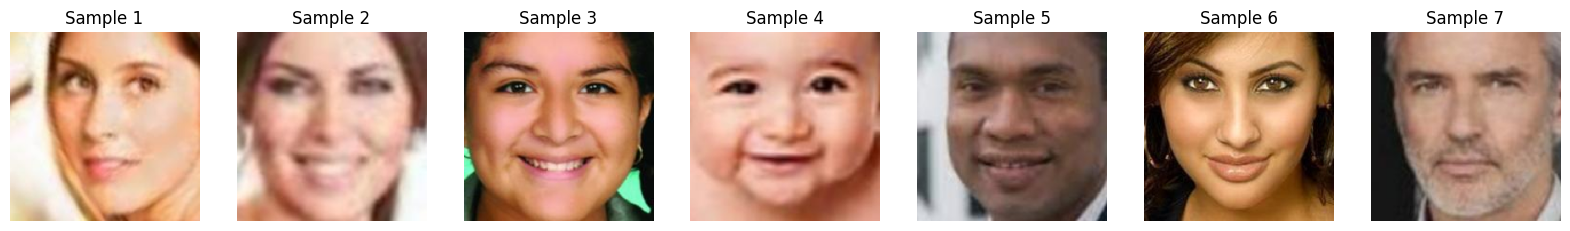

In [16]:
import matplotlib.pyplot as plt

# Function to display images
def display_sample_images(img_paths, num_samples=7):
    plt.figure(figsize=(20, 10))
    for i, img_path in enumerate(img_paths[:num_samples]):
        img = load_img(img_path, target_size=(224, 224))  # Adjust size as needed
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Sample {i + 1}")
        plt.axis('off')
    plt.show()

# Display sample images
display_sample_images(img_paths)

In [17]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [18]:
resnet = ResNet50(include_top=False, input_shape=(224,224,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
resnet = ResNet50(include_top=False, input_shape=(224,224,3))

resnet.trainable=False

output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512,activation='relu')(flatten)
dense3 = Dense(512,activation='relu')(flatten)

dense4 = Dense(512,activation='relu')(dense1)
dense5 = Dense(512,activation='relu')(dense2)
dense6 = Dense(512,activation='relu')(dense3)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)
output3 = Dense(5,activation='sigmoid',name='race')(dense6)

In [20]:
model = Model(inputs=resnet.input,outputs=[output1,output2,output3])

In [21]:
model.compile(
    optimizer='adam',
    loss={
        'age': 'mae',
        'gender': 'binary_crossentropy',
        'race': 'categorical_crossentropy'
    },
    metrics={
        'age': 'mae',
        'gender': 'accuracy',
        'race': 'accuracy'
    },
    loss_weights={
        'age': 1.0,
        'gender': 50.0,
        'race': 1.0
    }
)


In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 126,878,087 (484.00 MB)

 Trainable params: 103,290,375 (394.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [26]:
model.fit(
    train_generator,
    steps_per_epoch=len(train_img_paths) // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=len(test_img_paths) // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/5
592/592 ━━━━━━━━━━━━━━━━━━━━ 316s 507ms/step - age_loss: 16.3639 - age_mae: 16.3639 - gender_accuracy: 0.5214 - gender_loss: 75.1259 - loss: 93.7616 - race_accuracy: 0.3240 - race_loss: 2.2718 - val_age_loss: 15.5873 - val_age_mae: 15.5873 - val_gender_accuracy: 0.5281 - val_gender_loss: 34.5858 - val_loss: 51.6982 - val_race_accuracy: 0.4200 - val_race_loss: 1.5251
Epoch 2/5
592/592 ━━━━━━━━━━━━━━━━━━━━ 306s 508ms/step - age_loss: 14.7526 - age_mae: 14.7483 - gender_accuracy: 0.5213 - gender_loss: 34.7152 - loss: 51.0015 - race_accuracy: 0.3812 - race_loss: 1.5411 - val_age_loss: 15.0644 - val_age_mae: 15.1141 - val_gender_accuracy: 0.5281 - val_gender_loss: 34.5779 - val_loss: 51.2274 - val_race_accuracy: 0.2092 - val_race_loss: 1.5325
Epoch 3/5
592/592 ━━━━━━━━━━━━━━━━━━━━ 288s 487ms/step - age_loss: 14.4322 - age_mae: 14.4287 - gender_accuracy: 0.5196 - gender_loss: 34.7201 - loss: 50.6198 - race_accuracy: 0.4077 - race_loss: 1.4738 - val_age_loss: 14.5074 - val_age_mae: 

In [30]:
# Save the model with custom objects
model.save('multi_output_model.h5', save_format='h5')

# Load the model specifying custom objects if necessary
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import mae, categorical_crossentropy, binary_crossentropy

loaded_model = load_model(
    'multi_output_model.h5',
    custom_objects={
        'mae': mae,
        'categorical_crossentropy': categorical_crossentropy,
        'binary_crossentropy': binary_crossentropy
    }
)

In [31]:
# Function to preprocess and predict
def predict_image(img_path, model):
    img = load_img(img_path, target_size=(224, 224))  # Adjust size as needed
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Rescale

    predictions = model.predict(img_array)

    age_pred = predictions[0][0]
    gender_pred = predictions[1][0]
    race_pred = predictions[2][0]

    gender_label = 'Male' if gender_pred >= 0.5 else 'Female'
    race_label = np.argmax(race_pred)

    print(f"Predicted Age: {age_pred}")
    print(f"Predicted Gender: {gender_label}")
    print(f"Predicted Race: {race_label}")

In [35]:
# Test with a new image
test_img_path = '/content/istockphoto-1384357158-612x612.jpg'
predict_image(test_img_path, loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Age: [49.489735]
Predicted Gender: Female
Predicted Race: 0
